# The binomial distribution


Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 6

import matplotlib.pyplot as plt

import numpy as np

In [2]:
from inspect import getsourcelines

def show_code(func):
    lines, _ = getsourcelines(func)
    for line in lines:
        print(line, end='')

## Pmf

Here's a Pmf class that represents a Probability Mass Function, implemented using a Python dictionary that maps from possible outcomes to their probabilities.

In [3]:
from distribution import Pmf
show_code(Pmf)

class Pmf:
    
    def __init__(self, d=None):
        """Initializes the distribution.

        d: map from values to probabilities
        """
        self.d = {} if d is None else d

    def items(self):
        """Returns a sequence of (value, prob) pairs."""
        return self.d.items()
    
    def __repr__(self):
        """Returns a string representation of the object."""
        cls = self.__class__.__name__
        return '%s(%s)' % (cls, repr(self.d))

    def __getitem__(self, value):
        """Looks up the probability of a value."""
        return self.d.get(value, 0)

    def __setitem__(self, value, prob):
        """Sets the probability associated with a value."""
        self.d[value] = prob

    def __add__(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf or a scalar

        returns: new Pmf
        """
        if other == 0:
            return self

        pmf = Pmf()
        for v1, p1 in self

## The infamous biased coin

I'll create a Pmf that represents a biased coin, which has a 60% chance of landing heads and a 40% chance of landing tails.

If you are bothered by the fact that it is physically very difficult to bias a coin toss in this way, imagine a 10-sided die with `H` on 6 sides and `T` on 4 sides.

In [4]:
coin = Pmf(dict(H=0.6, T=0.4))
coin.display()

H 0.6
T 0.4


We can use the `+` operator to compute the possible outcomes of two coin tosses and their probabilities.

In [5]:
twice = coin + coin
twice.display()

HH 0.36
TT 0.16000000000000003
TH 0.24
HT 0.24


And similarly, the possible outcomes of three coin tosses.

In [6]:
thrice = sum([coin]*3)
thrice.display()

TTT 0.06400000000000002
HTT 0.096
THT 0.096
HHH 0.216
HHT 0.144
HTH 0.144
TTH 0.09600000000000002
THH 0.144


Notice that the outcomes take the order of the tosses into account, so `HT` is considered a different outcome from `TH`.

If we don't care about the order and we only care about the number of heads and tails, we can loop through the outcomes and count the number of heads.

In [7]:
from collections import Counter

for val, prob in sorted(thrice.items()):
    heads = val.count('H')
    print(heads, prob)

3 0.216
2 0.144
2 0.144
1 0.096
2 0.144
1 0.096
1 0.09600000000000002
0 0.06400000000000002


And we can make a new Pmf that maps from the total number of heads to the probability of that total.

In [8]:
def make_pmf_heads(coin, n):
    coins = sum([coin]*n)
    pmf = Pmf()
    for val, prob in coins.items():
        heads = val.count('H')
        pmf[heads] += prob
    return pmf

Here's what it looks like:

In [9]:
pmf_heads = make_pmf_heads(coin, 3)
pmf_heads.display()

0 0.06400000000000002
1 0.28800000000000003
2 0.43199999999999994
3 0.216


**Exerise:** Create `pmf_heads` for a few different values of `n` and plot them using the `plot_pmf` method.

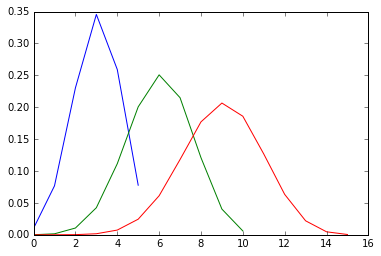

In [10]:
# Solution

for n in [5, 10, 15]:
    make_pmf_heads(coin, n).plot_pmf()

**Exerise:** Run the following example and see how long it takes.  Try it out with a few values of `n` and see how the run time depends on `n`.  

CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 164 ms


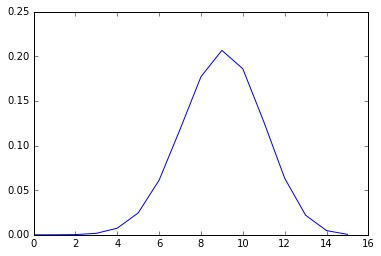

In [11]:
n = 15
%time make_pmf_heads(coin, n).plot_pmf()

This way of computing `pmf_heads` is not very efficient.  For `n` tosses, there are $2^n$ possible outcomes, and for large values of `n`, that is not tractable.

In the next section we will figure out a better way.

## The symbolic version

Looking at numerical output doesn't tell us much about how to generalize from this example.  We can learn more by replacing the numbers with symbols.

Here's a version of the Pmf where the probability of heads is the symbol `p`:

In [12]:
from sympy import symbols

p = symbols('p')
sym_coin = Pmf(dict(H=p, T=1-p))
sym_coin.display()

H p
T -p + 1


Now we can see the distribution of the number of heads, which I'll call `k`, after a few tosses:

In [13]:
make_pmf_heads(sym_coin, 2).display()

0 (-p + 1)**2
1 2*p*(-p + 1)
2 p**2


In [14]:
make_pmf_heads(sym_coin, 3).display()

0 (-p + 1)**3
1 3*p*(-p + 1)**2
2 3*p**2*(-p + 1)
3 p**3


In [15]:
make_pmf_heads(sym_coin, 4).display()

0 (-p + 1)**4
1 4*p*(-p + 1)**3
2 6*p**2*(-p + 1)**2
3 4*p**3*(-p + 1)
4 p**4


The general pattern is that probability of `k` heads after `n` tosses is the product of three terms

* The probability of `k` heads, which is `p**k`.
* The probability of `n-k` tails, which is `(1-p)**(n-k)`.
* An integer coefficient.

You might already know that the coefficient is the "binomial coefficient", which is written $n \choose k$ and pronounced "n choose k".  But pretend for a moment that you don't know that and let's figure it out.

## The binomial coefficient

To make the pattern easier to see, I'll create a fair coin where `p = 1-p = 1/2`

In [16]:
fair_coin = Pmf(dict(H=p, T=p))
fair_coin.display()

H p
T p


Now the probability of all outcomes is `p**n`

In [17]:
thrice = sum([fair_coin]*3)
thrice.display()

TTT p**3
HTT p**3
THT p**3
HHH p**3
HHT p**3
HTH p**3
TTH p**3
THH p**3


So when we count the number of heads, it is easier to see the coefficients.

In [18]:
pmf_heads = make_pmf_heads(fair_coin, 3)
pmf_heads.display()

0 p**3
1 3*p**3
2 3*p**3
3 p**3


And even easier if we divide through by `p**n`

In [19]:
for val, prob in pmf_heads.items():
    print(val, prob / p**3)

0 1
1 3
2 3
3 1


We can assemble the code from the previous cells into a function that prints the coefficients for a given value of `n`:

In [20]:
def coefficients(n):
    fair_coin = Pmf(dict(H=p, T=p))
    pmf_heads = make_pmf_heads(fair_coin, n)
    for val, prob in pmf_heads.items():
        print(prob / p**n, end=' ')
    print()

Here are the coefficients for `n=3`

In [21]:
coefficients(3)

1 3 3 1 


And here they are for `n` in the range from `1` to `9`

In [22]:
for n in range(1, 10):
    coefficients(n)

1 1 
1 2 1 
1 3 3 1 
1 4 6 4 1 
1 5 10 10 5 1 
1 6 15 20 15 6 1 
1 7 21 35 35 21 7 1 
1 8 28 56 70 56 28 8 1 
1 9 36 84 126 126 84 36 9 1 


Now we can look for patterns.

* If we flip the coin `n` times, the coefficient associated with getting `k` heads is `1` if `k` is `0` or `n`.

* Otherwise, the `(n, k)` coefficient is the sum of two coefficients from the previous row: `(n-1, k)` and `(n-1, k-1)`

We can use these observations to compute the binomial coefficient recursively:

In [23]:
def binomial_coefficient(n, k):
    if k==0 or k==n:
        return 1
    return binomial_coefficient(n-1, k) + binomial_coefficient(n-1, k-1)

And it yields the same results.

In [24]:
binomial_coefficient(9, 5)

126

Here are the results for `n` from 1 to 9 again.

In [25]:
for n in range(1, 10):
    for k in range(n+1):
        print(binomial_coefficient(n, k), end=' ')
    print()

1 1 
1 2 1 
1 3 3 1 
1 4 6 4 1 
1 5 10 10 5 1 
1 6 15 20 15 6 1 
1 7 21 35 35 21 7 1 
1 8 28 56 70 56 28 8 1 
1 9 36 84 126 126 84 36 9 1 


So far so good.

**Exercise:**  SciPy provides a "special" function called `binom` that you can import from `scipy.special`.  Test it to confirm that it is consistent with our function.

Note that `scipy.special.binom` returns a float, so for large values of `n` it is only approximate.

In [26]:
# Solution

from scipy.special import binom
binom(9, 5)

126.000000

**Exercise:** The recursive implementation of `binomial_coefficient` is inefficient for large values of `n` because it computes the same intermediate results many times.  You can speed it up (a lot!) by memoizing previously computed results.

Write a version called `fast_binom` that caches results in a dictionary.

In [27]:
# Solution

def fast_binom(n, k, cache={}):
    if k==0 or k==n:
        return 1
    try:
        return cache[n, k]
    except KeyError:
        res = fast_binom(n-1, k) + fast_binom(n-1, k-1)
        cache[n, k] = res
        return res

for n in range(1, 10):
    for k in range(n+1):
        print(binomial_coefficient(n, k), end=' ')
    print()

1 1 
1 2 1 
1 3 3 1 
1 4 6 4 1 
1 5 10 10 5 1 
1 6 15 20 15 6 1 
1 7 21 35 35 21 7 1 
1 8 28 56 70 56 28 8 1 
1 9 36 84 126 126 84 36 9 1 


## The Binomial PMF

Bringing it all together, we have

$PMF(k; n,p) = {n \choose k} p^k (1-p)^{n-k}$

This equation can be interpreted at two levels:

* If you want to know the probability of `k` heads in `n` tosses, where the probability of heads in each toss is `p`, you can use the formula on the right to compute it.

* More abstractly, this equation states that the formula on the right is the PMF of `k` with the parameters `n` and `p`.

To make the difference between these interpretations clear, let's look at two functions:

    1.  `eval_binomial_pmf` evaluates this formula for given values of `k`, `n`, and `p`.
    2.  `make_binomial_pmf` evaluates the formula for a range of values of `k`, and returns the resulting `Pmf` object.
    
First, here's `eval_binomial_pmf`:

In [28]:
from scipy.special import binom

def eval_binomial_pmf(k, n, p):
    return binom(n, k) * p**k * (1-p)**(n-k)

We can use it to compute probabilities for each value of `k` directly:

In [29]:
n = 3
p = 0.6

for k in range(n+1):
    print(k, eval_binomial_pmf(k, n, p))

0 0.064
1 0.288
2 0.432
3 0.216


And here's the corresponding `pmf_heads` for comparison

In [30]:
coin = Pmf(dict(H=p, T=1-p))
make_pmf_heads(coin, n).display()

0 0.06400000000000002
1 0.28800000000000003
2 0.43199999999999994
3 0.216


They are the same, at least within floating point error.

Now here's `make_binomial_pmf`

In [31]:
def make_binomial_pmf(n, p):
    pmf = Pmf()
    for k in range(n+1):
        pmf[k] = eval_binomial_pmf(k, n, p)
    return pmf

We can use it to make a Pmf that contains the possible values of `k` and their probabilities:

In [32]:
pmf = make_binomial_pmf(n, p)
pmf.display()

0 0.064
1 0.288
2 0.432
3 0.216


Here's what the distribution of `k` looks like for given values of `n` and `p`:

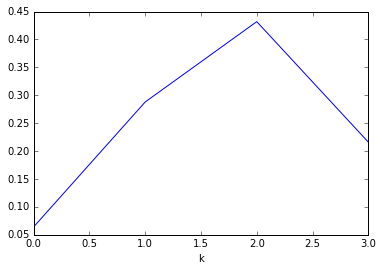

In [33]:
pmf.plot_pmf()
plt.xlabel('k');

If we hold `p` constant, we can see how the distribution of `k` changes as `n` increases

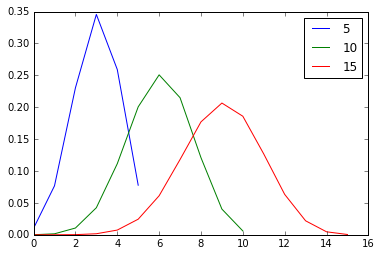

In [34]:
p = 0.6
for n in [5, 10, 15]:
    make_binomial_pmf(n, p).plot_pmf(label=n)
plt.legend();

**Exercise:** Keeping `n=10`, plot the distribution of `k` for a few different values of `p`.

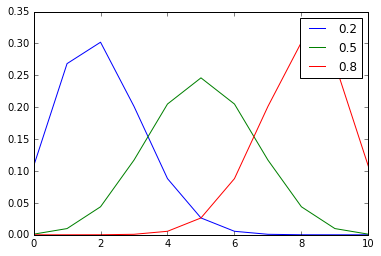

In [35]:
# Solution

n = 10
for p in [0.2, 0.5, 0.8]:
    make_binomial_pmf(n, p).plot_pmf(label=p)
plt.legend();

The Pmf objects we just created represent differnet distributions of `k` based on different values of the parameters `n` and `p`.

As `make_binomial_pmf` demonstrates, if you give me `n` and `p`, I can compute a distribution of `k`.

Speaking casually, people sometimes refer to this equation as the PMF of "the" binomial distribution:

$PMF(k; n,p) = {n \choose k} p^k (1-p)^{n-k}$

More precisely, it is a "family" of distributions, where the parameters `n` and `p` specify a particular member of the family.

**Exercise:**  Suppose you toss a fair coin 10 times.  What is the probability of getting 5 heads?

If you run this experiment many times, what is the mean number of heads you expect?  What is the variance in the number of heads?

In [36]:
# Solution

n = 10
p = 0.5
pmf = make_binomial_pmf(n, p)
print(pmf[5])
print(pmf.mean())
print(pmf.var())

0.24609375
5.0
2.5


**Exercise:**  Suppose you toss a fair coin 10 times.  What is the probability of getting fewer than 5 heads?

If you run this experiment many times, what is the median number of heads you expect?  What is the interquartile range (IQR) in the number of heads?

Hint: You might want to make a CDF.

In [37]:
# Solution

from distribution import compute_cumprobs, Cdf

xs, ps = compute_cumprobs(pmf.d)
cdf = Cdf(xs, ps)
print(cdf[4])

low, median, high = cdf.values([0.25, 0.5, 0.75])
print(median, high-low)

0.376953125
5 2
